# Descrição do Case

<b>SQL Review: Case OLIST</b>

Fonte de dados: https://www.kaggle.com/olistbr/brazilian-ecommerce

<b>O impacto de atrasos</b>

O atraso na entrega é motivo de frustração para clientes de qualquer e-commerce. Gostaríamos de compreender melhor se existem causas estruturais para o atraso e compreender se esses atrasos geram um impacto na percepção do cliente sobre os pedidos.

* 1.1. A nossa rede de sellers está espalhada pelo Brasil, assim como nossos clientes. Será que a distância entre sellers e clientes impacta o atraso na entrega?

* 1.2. A diversidade de produtos vendidos através de nossa plataforma é grande, será que os atrasos estão concentrados em certos tipos de produto?

* 1.3. O impacto sobre a experiência do cliente pode ser mensurado através das diferentes reviews. Qual o impacto dos atrasos sobre estes reviews? Qual seria o impacto se reduzíssemos o número de atrasos em 50%?

* 1.4. (BONUS) O tempo de entrega previsto é um dos principais determinantes na escolha de um vendedor especifico em marketplaces online. No entanto ao reduzir a previsão do tempo de entrega corremos o risco de aumentar o número de clientes insatisfeitos. Atualmente as previsões de entrega estão sendo feitas de maneira assertiva? Quais dados você precisaria para analisar os beneficios e riscos de uma previsão de tempo de entrega mais otimista?

<b>DICAS</b>

- Não se preocupe em medir a distância real: busque construir um indicador categórico que represente indiretamente a distância entre clientes e sellers.

- Qual atributo dos produtos pode dificultar diretamente o frete?

- Adote premissas!

# Preparação

Importações

In [1]:
import pandas as pd
import sqlalchemy as sa
import seaborn as sns

Funções úteis

In [2]:
def read_sql(query, engine):
    with engine.begin() as conn:
        results = pd.read_sql_query(sa.text(query), conn)
    return results

def execute_sql(query, engine):
    with engine.begin() as conn:
        results = conn.execute(sa.text(query))
    return results

Configuração do display do pandas

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Configuração da conexão com o banco de dados

In [4]:
user = "aluno"
password = "123456"
url_banco = "ironhack.czlp1hxhb7ih.us-east-1.rds.amazonaws.com"
nome_db = "olist"
conn_str = f"mysql+pymysql://{user}:{password}@{url_banco}/{nome_db}"
engine = sa.create_engine(conn_str)

# Queries

## Questão 1

O query abaixo calcula a quantidade de atrasos a partir de um índice binário: se o cliente recebeu ou não o pedido dentro do prazo.

In [5]:
# Questão 1 - Distância seller-customer
query_seller_customer_distance_sum = """WITH seller_customer_distance AS (
	SELECT
		tc.customer_zip_code_prefix AS customer_zip,
		ts.seller_zip_code_prefix AS seller_zip,
		tc.customer_state AS customer_state,
		ts.seller_state  AS seller_state,
		CASE 
			WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
			ELSE 0
		END AS atraso,
		CASE 
			WHEN tc.customer_state = ts.seller_state  THEN 1
			ELSE 0
		END AS mesmo_estado
	FROM 
		t_customer tc JOIN
		t_order to2 ON (to2.customer_id = tc.customer_id) JOIN 
		t_order_item toi ON (toi.order_id = to2.order_id) JOIN 
		t_seller ts ON (ts.seller_id = toi.seller_id)
	ORDER BY
		mesmo_estado DESC)
SELECT
	mesmo_estado,
	sum(atraso) AS qtd_atrasos
FROM 
	seller_customer_distance
GROUP BY
	mesmo_estado;
"""

O query abaixo retorna todos os dados dos pedidos em relação ao estado do vendedor e o estado do cliente, facilitando a construção de uma tabela pivô.

In [6]:
query_seller_customer_distance = """SELECT
	ts.seller_state  AS seller_state,
	tc.customer_state AS customer_state,
	sum(CASE 
		WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
		ELSE 0
	END) AS atraso,
	CASE 
		WHEN tc.customer_state = ts.seller_state  THEN 1
		ELSE 0
	END AS mesmo_estado,
    count(*) AS total_pedidos,
    round((sum(CASE 
		WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
		ELSE 0
	END) / count(*)), 4) * 100 AS taxa_atraso
FROM 
	t_customer tc JOIN
	t_order to2 ON (to2.customer_id = tc.customer_id) JOIN 
	t_order_item toi ON (toi.order_id = to2.order_id) JOIN 
	t_seller ts ON (ts.seller_id = toi.seller_id)
GROUP BY 
	tc.customer_state, ts.seller_state 
HAVING 
	total_pedidos > 100
ORDER BY
	taxa_atraso DESC;
"""

## Questão 2

In [7]:
# Questão 2 - Dividir por categoria os produtos
query_category_late = """SELECT
	product_category_name,
	count(*) AS qtd_total,
	sum(CASE 
			WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
			ELSE 0
	END) AS atraso,
	sum(CASE 
			WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
			ELSE 0
	END) / count(*) AS taxa_atrasos
FROM 
	t_product tp JOIN
	t_order_item toi ON (tp.product_id = toi.product_id) JOIN 
	t_order to2 ON (toi.order_id = to2.order_id)
GROUP BY 
	product_category_name
HAVING 
	qtd_total >= 100
ORDER BY 
	taxa_atrasos DESC;"""

## Questão 3

In [8]:
# Questão 3 - Impacto reviews. Impacto se reduzíssemos o número de atrasos em 50%?
query_review_score_late = """SELECT 
	tor.review_score,
	count(*) AS total_reviews,
	sum(CASE 
			WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
			ELSE 0
	END) AS atraso,
	sum(CASE 
			WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
			ELSE 0
	END) / count(*) AS proporcao
FROM 
	t_customer tc JOIN
	t_order to2 ON (to2.customer_id = tc.customer_id) JOIN 
	t_order_review tor ON (tor.order_id = to2.order_id)
GROUP BY 
	tor.review_score
ORDER BY 
	tor.review_score;
"""

query_review_avg = """SELECT 
	count(*) AS qtd,
	tb_atraso.COL_ATRASO AS atraso,
	avg(SCORE) AS media_pontuacao
FROM
	(
		SELECT 
			tor.review_score as SCORE, 
			CASE
				WHEN to2.order_delivered_customer_date > to2.order_estimated_delivery_date THEN 1
				ELSE 0
			END AS COL_ATRASO
		FROM 
			olist.t_customer tc JOIN
			olist.t_order to2 ON (tc.customer_id = to2.customer_id) JOIN 
			olist.t_order_review tor ON (tor.order_id = to2.order_id)
	) AS tb_atraso
GROUP BY 
	tb_atraso.COL_ATRASO"""

## Questão Bônus

In [9]:
query_estimativa_entrega = """SELECT 
	count(*) AS qtd_total,
	sum(atraso) AS total_atrasos,
	sum(atraso) / count(*) AS media_atrasos
FROM 
	(
	SELECT 
		to2.order_estimated_delivery_date, 
		to2.order_delivered_customer_date,
		CASE
			WHEN to2.order_delivered_customer_date > ADDDATE(to2.order_estimated_delivery_date, 1) THEN 1
			ELSE 0
		END AS atraso,
		datediff(str_to_date(to2.order_estimated_delivery_date, '%Y-%m-%d'), str_to_date(to2.order_delivered_customer_date, '%Y-%m-%d'))	
	FROM 
		t_order to2
	) AS tb_late"""

# Questão 1

In [10]:
tb_seller_customer_distance = read_sql(query_seller_customer_distance, engine)

In [11]:
# Atrasos por distância: se mesmo estado ou não
read_sql(query_seller_customer_distance_sum, engine)

,mesmo_estado,qtd_atrasos
0,0,6331.0
1,1,2384.0


In [12]:
tb_seller_customer_distance.head(15)

,seller_state,customer_state,atraso,mesmo_estado,total_pedidos,taxa_atraso
0,MA,SP,35.0,0,131,26.72
1,SP,AL,69.0,0,286,24.13
2,SP,MA,122.0,0,566,21.55
3,SP,SE,43.0,0,241,17.84
4,SP,PI,65.0,0,378,17.20
5,PR,BA,25.0,0,167,14.97
6,SP,CE,168.0,0,1134,14.81
7,SP,RJ,1396.0,0,9688,14.41
8,SP,BA,388.0,0,2708,14.33
9,SP,ES,227.0,0,1647,13.78


In [38]:
print(tb_seller_customer_distance[['seller_state', 'customer_state', 'atraso', 'total_pedidos', 'taxa_atraso']].head(5).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>seller_state</th>
      <th>customer_state</th>
      <th>atraso</th>
      <th>total_pedidos</th>
      <th>taxa_atraso</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>MA</td>
      <td>SP</td>
      <td>35.0</td>
      <td>131</td>
      <td>26.72</td>
    </tr>
    <tr>
      <th>1</th>
      <td>SP</td>
      <td>AL</td>
      <td>69.0</td>
      <td>286</td>
      <td>24.13</td>
    </tr>
    <tr>
      <th>2</th>
      <td>SP</td>
      <td>MA</td>
      <td>122.0</td>
      <td>566</td>
      <td>21.55</td>
    </tr>
    <tr>
      <th>3</th>
      <td>SP</td>
      <td>SE</td>
      <td>43.0</td>
      <td>241</td>
      <td>17.84</td>
    </tr>
    <tr>
      <th>4</th>
      <td>SP</td>
      <td>PI</td>
      <td>65.0</td>
      <td>378</td>
      <td>17.20</td>
    </tr>
  </tbody>
</table>


In [13]:
pivot_distance = pd.pivot_table(tb_seller_customer_distance, values='taxa_atraso', index=['seller_state'], columns=['customer_state'])

In [14]:
pivot_distance.fillna('------')

customer_state,AL,AM,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RS,SC,SE,SP,TO
seller_state,,,,,,,,,,,,,,,,,,,,,,,,
BA,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,5.23,------
DF,------,------,------,------,------,------,------,------,0.93,------,------,------,------,------,------,------,8.18,------,------,------,------,------,2.68,------
ES,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,9.24,------
GO,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,3.55,------
MA,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,26.72,------
MG,------,------,9.53,------,2.71,6.31,2.89,------,2.98,------,------,------,------,7.56,------,1.69,8.73,------,------,4.76,8.68,------,3.98,------
PE,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,------,2.83,------
PR,------,------,14.97,------,4.49,8.55,------,------,5.54,------,------,------,------,11.76,------,4.23,12.73,------,------,4.6,7.54,------,3.58,------
RJ,------,------,10.34,------,10.53,1.8,7.09,------,6.91,------,------,------,------,12.04,------,7.69,5.97,------,------,9.25,9.42,------,8.23,------


In [35]:
print(pivot_distance.fillna('----').to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>customer_state</th>
      <th>AL</th>
      <th>AM</th>
      <th>BA</th>
      <th>CE</th>
      <th>DF</th>
      <th>ES</th>
      <th>GO</th>
      <th>MA</th>
      <th>MG</th>
      <th>MS</th>
      <th>MT</th>
      <th>PA</th>
      <th>PB</th>
      <th>PE</th>
      <th>PI</th>
      <th>PR</th>
      <th>RJ</th>
      <th>RN</th>
      <th>RO</th>
      <th>RS</th>
      <th>SC</th>
      <th>SE</th>
      <th>SP</th>
      <th>TO</th>
    </tr>
    <tr>
      <th>seller_state</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <

<Axes: xlabel='customer_state', ylabel='seller_state'>

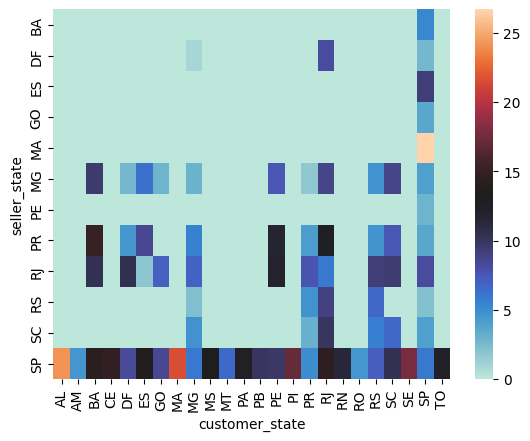

In [15]:
sns.heatmap(pivot_distance.fillna(0), cmap='icefire')

# Questão 2

In [16]:
tb_categories = read_sql(query_category_late, engine)

In [17]:
tb_categories = tb_categories.drop(index=8, axis=0)

In [18]:
tb_categories

,product_category_name,qtd_total,atraso,taxa_atrasos
0,audio,364,46.0,0.1264
1,fashion_underwear_e_moda_praia,131,16.0,0.1221
2,artigos_de_natal,153,18.0,0.1176
3,livros_tecnicos,267,29.0,0.1086
4,casa_conforto,434,44.0,0.1014
5,construcao_ferramentas_iluminacao,304,30.0,0.0987
6,alimentos,510,49.0,0.0961
7,eletronicos,2767,266.0,0.0961
9,beleza_saude,9670,858.0,0.0887
10,moveis_escritorio,1691,149.0,0.0881


<Axes: xlabel='taxa_atrasos', ylabel='product_category_name'>

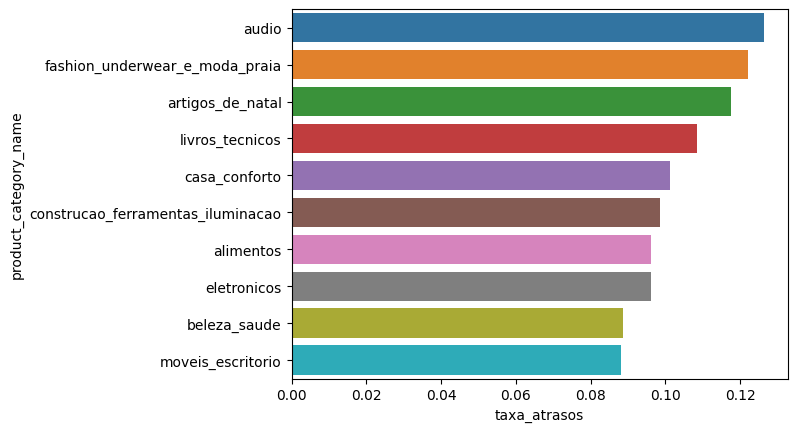

In [19]:
sns.barplot(data=tb_categories.head(10), x='taxa_atrasos', y='product_category_name')

In [40]:
print(tb_categories.head(10).to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>product_category_name</th>
      <th>qtd_total</th>
      <th>atraso</th>
      <th>taxa_atrasos</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>audio</td>
      <td>364</td>
      <td>46.0</td>
      <td>0.1264</td>
    </tr>
    <tr>
      <td>fashion_underwear_e_moda_praia</td>
      <td>131</td>
      <td>16.0</td>
      <td>0.1221</td>
    </tr>
    <tr>
      <td>artigos_de_natal</td>
      <td>153</td>
      <td>18.0</td>
      <td>0.1176</td>
    </tr>
    <tr>
      <td>livros_tecnicos</td>
      <td>267</td>
      <td>29.0</td>
      <td>0.1086</td>
    </tr>
    <tr>
      <td>casa_conforto</td>
      <td>434</td>
      <td>44.0</td>
      <td>0.1014</td>
    </tr>
    <tr>
      <td>construcao_ferramentas_iluminacao</td>
      <td>304</td>
      <td>30.0</td>
      <td>0.0987</td>
    </tr>
    <tr>
      <td>alimentos</td>
      <td>510</td>
      <td>49.0</td>
      <td>0.0

In [41]:
print(tb_categories.tail(5).to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>product_category_name</th>
      <th>qtd_total</th>
      <th>atraso</th>
      <th>taxa_atrasos</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>moveis_cozinha_area_de_servico_jantar_e_jardim</td>
      <td>281</td>
      <td>12.0</td>
      <td>0.0427</td>
    </tr>
    <tr>
      <td>agro_industria_e_comercio</td>
      <td>212</td>
      <td>9.0</td>
      <td>0.0425</td>
    </tr>
    <tr>
      <td>market_place</td>
      <td>311</td>
      <td>13.0</td>
      <td>0.0418</td>
    </tr>
    <tr>
      <td>telefonia_fixa</td>
      <td>264</td>
      <td>11.0</td>
      <td>0.0417</td>
    </tr>
    <tr>
      <td>climatizacao</td>
      <td>297</td>
      <td>11.0</td>
      <td>0.0370</td>
    </tr>
  </tbody>
</table>


# Questão 3

In [20]:
tb_review_sum = read_sql(query_review_score_late, engine)

In [21]:
tb_review_avg = read_sql(query_review_avg, engine)

In [22]:
tb_review_avg

,qtd,atraso,media_pontuacao
0,71916,0,4.2121
1,6000,1,2.5578


In [23]:
tb_review_sum

,review_score,total_reviews,atraso,proporcao
0,1,9001,2786.0,0.3095
1,2,2468,462.0,0.1872
2,3,6413,689.0,0.1074
3,4,15080,745.0,0.0494
4,5,44954,1318.0,0.0293


<Axes: xlabel='atraso', ylabel='media_pontuacao'>

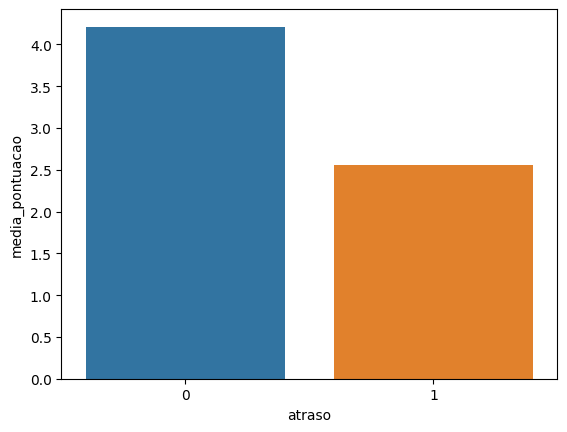

In [24]:
sns.barplot(data=tb_review_avg.head(10), x='atraso', y='media_pontuacao')

<Axes: xlabel='review_score', ylabel='proporcao'>

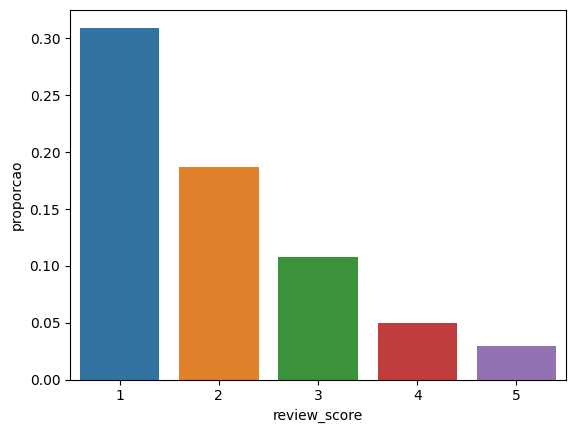

In [25]:
sns.barplot(data=tb_review_sum.head(10), x='review_score', y='proporcao')

In [26]:
tb_review_avg.columns

Index(['qtd', 'atraso', 'media_pontuacao'], dtype='object')

In [27]:
media_geral = (tb_review_avg['qtd'] * tb_review_avg['media_pontuacao']).sum()/tb_review_avg['qtd'].sum()
media_geral

4.0847089634991525

In [28]:
tb_review_avg_50menos = tb_review_avg.copy()
tb_review_avg_50menos.loc[tb_review_avg_50menos['qtd'] == 6000, 'qtd'] = 3000
tb_review_avg_50menos.loc[tb_review_avg_50menos['qtd'] == 71916, 'qtd'] = 74916
tb_review_avg_50menos

,qtd,atraso,media_pontuacao
0,74916,0,4.2121
1,3000,1,2.5578


In [29]:
media_geral_50 = (tb_review_avg_50menos['qtd'] * tb_review_avg_50menos['media_pontuacao']).sum()/tb_review_avg_50menos['qtd'].sum()
media_geral_50

4.148404481749577

In [30]:
medias_reviews = pd.DataFrame({'Média atual':media_geral, 'Média - 50% menos atrasos':media_geral_50}, index=[0])
medias_reviews

,Média atual,Média - 50% menos atrasos
0,4.084709,4.148404


# Questão 4

In [31]:
read_sql(query_estimativa_entrega, engine)

,qtd_total,total_atrasos,media_atrasos
0,99441,6535.0,0.0657
